In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from tqdm import tqdm


In [2]:
# ---- Step 1: Parse the Data ---- #
def parse_line(line):
    parts = line.strip().split('|')
    return [part.strip() for part in parts if part.strip()]

def parse_header(parts):
    impression_id = parts[0].split()[0]
    label = None
    propensity = None
    banner_features = {}
    
    for part in parts[1:]:
        if part.startswith('l'):
            label = float(part.split()[1])
        elif part.startswith('p'):
            propensity = float(part.split()[1])
        elif part.startswith('f'):
            tokens = part.split()[1:]
            for token in tokens:
                key, val = token.split(':')
                banner_features[int(key)] = float(val)
    return impression_id, label, propensity, banner_features

def parse_candidate(parts):
    impression_id = parts[0].split()[0]
    candidate_features = {}
    for part in parts[1:]:
        if part.startswith('f'):
            tokens = part.split()[1:]
            for token in tokens:
                key, val = token.split(':')
                candidate_features[int(key)] = float(val)
    return impression_id, candidate_features

def parse_file_generator(file_path):
    current_impression = None
    with open(file_path, 'r') as f:
        for line in f:
            parts = parse_line(line)
            if not parts:
                continue
            if any(part.startswith('l') for part in parts) and any(part.startswith('p') for part in parts):
                if current_impression is not None:
                    yield current_impression
                impression_id, label, propensity, banner_features = parse_header(parts)
                current_impression = {
                    "impression_id": impression_id,
                    "label": label,
                    "propensity": propensity,
                    "banner_features": banner_features,
                    "candidates": []
                }
            else:
                imp_id_candidate, candidate_features = parse_candidate(parts)
                if current_impression and current_impression["impression_id"] == imp_id_candidate:
                    current_impression["candidates"].append(candidate_features)
        if current_impression is not None:
            yield current_impression


In [3]:
# ---- Step 2: Run EDA ---- #
# file_path = "criteo_train.txt/criteo_train.txt"
file_path = "criteo_train_small.txt/criteo_train_small.txt"


In [4]:

# 1. Check the number of impressions
num_impressions = sum(1 for _ in parse_file_generator(file_path))
print(f"Total number of impressions: {num_impressions}")


Total number of impressions: 20000


In [5]:

# 2. Check the average number of candidates per impression
total_candidates = 0
for imp in parse_file_generator(file_path):
    total_candidates += len(imp["candidates"])
avg_candidates = total_candidates / num_impressions
print(f"Avg number of candidates per impression: {avg_candidates:.2f}")


Avg number of candidates per impression: 11.29


Max candidates per impression: 70
Min candidates per impression: 0


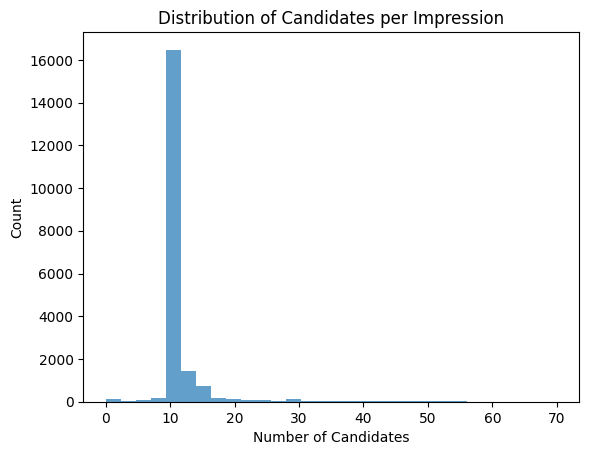

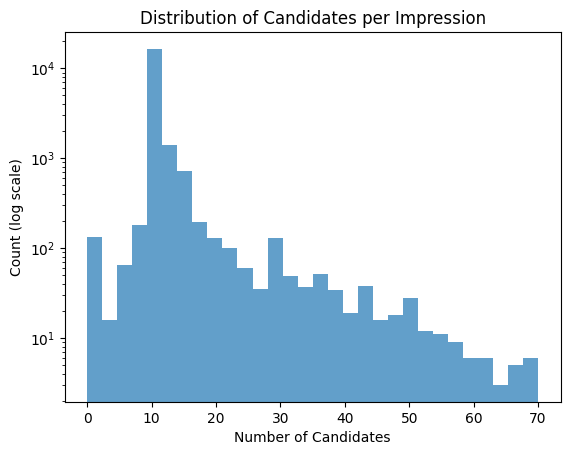

In [6]:

# 3. Distribution of candidates per impression with min, max, and plot
candidates_per_imp = [len(imp["candidates"]) for imp in parse_file_generator(file_path)]
print(f"Max candidates per impression: {max(candidates_per_imp)}")
print(f"Min candidates per impression: {min(candidates_per_imp)}")
plt.hist(candidates_per_imp, bins=30, alpha=0.7)
plt.xlabel("Number of Candidates")
plt.ylabel("Count")
plt.title("Distribution of Candidates per Impression")
plt.show()

# plot in log scale
plt.hist(candidates_per_imp, bins=30, alpha=0.7)
plt.yscale('log')
plt.xlabel("Number of Candidates")
plt.ylabel("Count (log scale)")
plt.title("Distribution of Candidates per Impression")
plt.show()


In [7]:

# 4. Check unique banner feature keys
banner_feature_keys = set()
for imp in parse_file_generator(file_path):
    banner_feature_keys.update(imp["banner_features"].keys())
print(f"Unique banner feature keys: {banner_feature_keys}")


Unique banner feature keys: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227

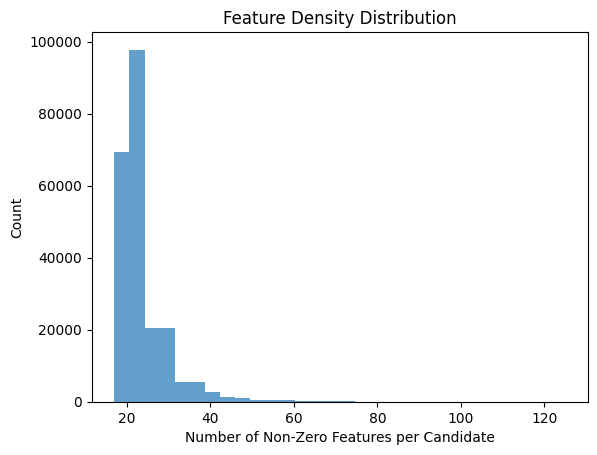

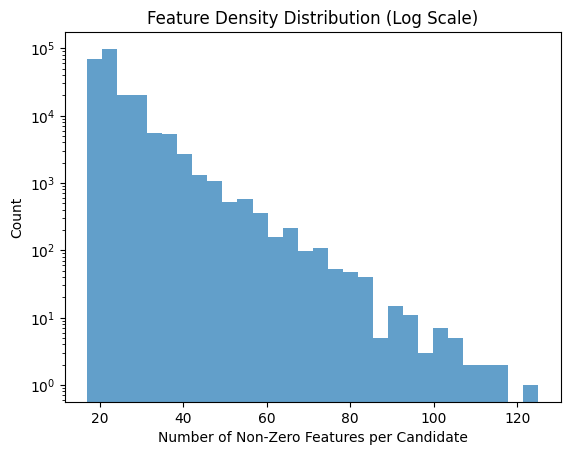

In [8]:

# 5. Check feature density (sparse vs. dense data) and plot
feature_counts = []
for imp in parse_file_generator(file_path):
    for candidate in imp["candidates"]:
        feature_counts.append(len(candidate))
plt.hist(feature_counts, bins=30, alpha=0.7)
plt.xlabel("Number of Non-Zero Features per Candidate")
plt.ylabel("Count")
plt.title("Feature Density Distribution")
plt.show()

# plot in log scale
plt.hist(feature_counts, bins=30, alpha=0.7)
plt.yscale('log')
plt.xlabel("Number of Non-Zero Features per Candidate")
plt.ylabel("Count")
plt.title("Feature Density Distribution (Log Scale)")
plt.show()


In [9]:

# 6. Proportion of impressions where a click occurred
num_clicks = sum(1 for imp in parse_file_generator(file_path) if imp["label"] > 0)
ctr = num_clicks / num_impressions
print(f"Click-through rate (CTR): {ctr:.4f}")


Click-through rate (CTR): 1.0000


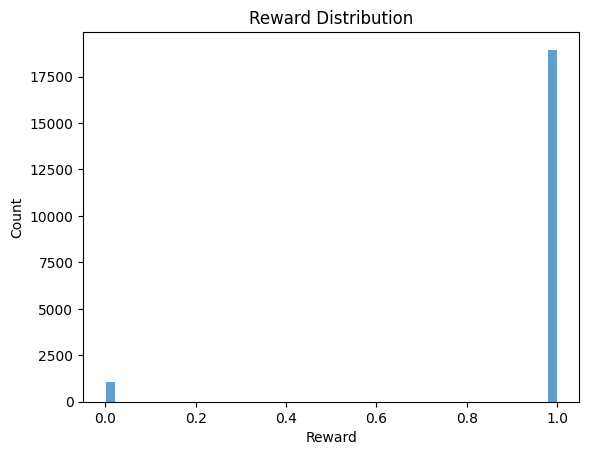

In [10]:

# 7. Histogram of rewards
rewards = [imp["label"] for imp in parse_file_generator(file_path)]
plt.hist(rewards, bins=50, alpha=0.7)
plt.xlabel("Reward")
plt.ylabel("Count")
plt.title("Reward Distribution")
plt.show()


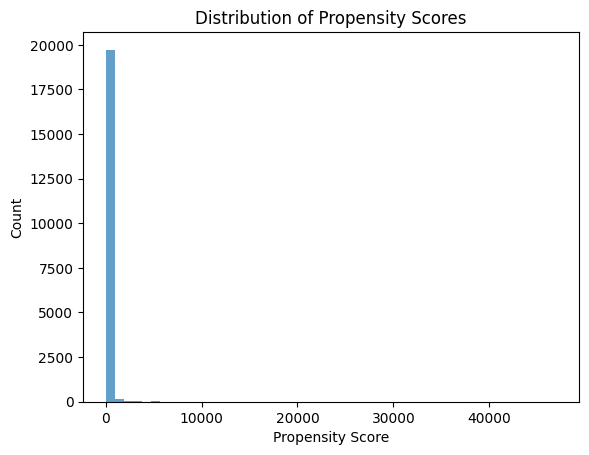

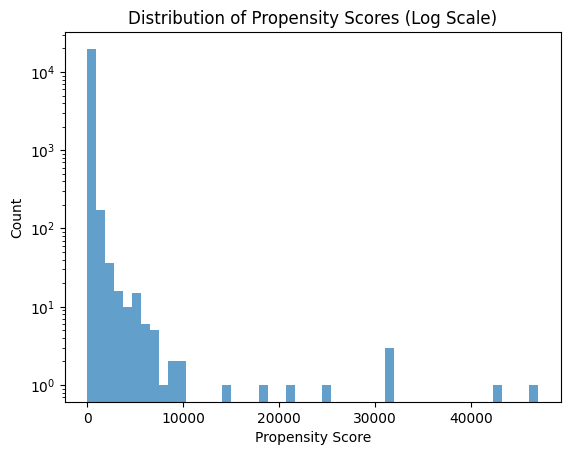

In [11]:

# 8. Propensity Score Distribution
propensities = [imp["propensity"] for imp in parse_file_generator(file_path)]
plt.hist(propensities, bins=50, alpha=0.7)
plt.xlabel("Propensity Score")
plt.ylabel("Count")
plt.title("Distribution of Propensity Scores")
plt.show()

# plot in log scale
plt.hist(propensities, bins=50, alpha=0.7)
plt.xlabel("Propensity Score")
plt.ylabel("Count")
plt.title("Distribution of Propensity Scores (Log Scale)")
plt.yscale('log')
plt.show()


In [12]:

# 9. Check how many features are missing (i.e., unused) in most candidates
feature_usage = collections.defaultdict(int)
for imp in parse_file_generator(file_path):
    for candidate in imp["candidates"]:
        for feature in candidate.keys():
            feature_usage[feature] += 1
sorted_features = sorted(feature_usage.items(), key=lambda x: x[1], reverse=True)
print(f"Top 10 most common features: {sorted_features[:10]}")
print(f"Top 10 least common features: {sorted_features[-10:]}")


Top 10 most common features: [(0, 225883), (1, 225883), (2, 225883), (12, 191996), (14, 191996), (21, 190720), (49, 127732), (192, 103276), (52, 99243), (11, 98151)]
Top 10 least common features: [(28936, 1), (31009, 1), (31010, 1), (39703, 1), (18647, 1), (22650, 1), (31803, 1), (31802, 1), (18582, 1), (18584, 1)]


In [ ]:

# # 10. Correlation between click probability and some key banner features
# import pandas as pd
# data = []
# for imp in tqdm(parse_file_generator(file_path), total=10000):  # Limit for performance
#     row = imp["banner_features"].copy()
#     row["label"] = imp["label"]
#     data.append(row)
# df = pd.DataFrame(data)
# print(df.corr()["label"].sort_values(ascending=False))


# # 11. Do certain ads/products have much higher selection probability than others?
# selection_counts = collections.defaultdict(int)
# for imp in tqdm(parse_file_generator(file_path), total=10000):
#     if imp["candidates"]:
#         selected_id = imp["candidates"][0]  # Assume first candidate is displayed
#         selection_counts[selected_id] += 1
# top_selected = sorted(selection_counts.items(), key=lambda x: x[1], reverse=True)[:10]
# print(f"Top 10 most frequently selected candidates: {top_selected}")


# # 12. Is the logging policy biased towards high-reward items?
# rewards = []
# propensities = []
# for imp in tqdm(parse_file_generator(file_path), total=10000):
#     rewards.append(imp["label"])
#     propensities.append(imp["propensity"])
# sns.scatterplot(x=propensities, y=rewards)
# plt.xlabel("Propensity Score")
# plt.ylabel("Reward")
# plt.title("Relationship between Propensity and Reward")
# plt.show()
